




Training ResNet50...
Epoch 1/2


47/47 [==============================] - 364s 7s/step - loss: 0.8928 - accuracy: 0.7933 - val_loss: 2.6635 - val_accuracy: 0.0980
Epoch 2/2
47/47 [==============================] - 329s 7s/step - loss: 0.0890 - accuracy: 0.9729 - val_loss: 3.7428 - val_accuracy: 0.0980

Model Summary for ResNet50:
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)    

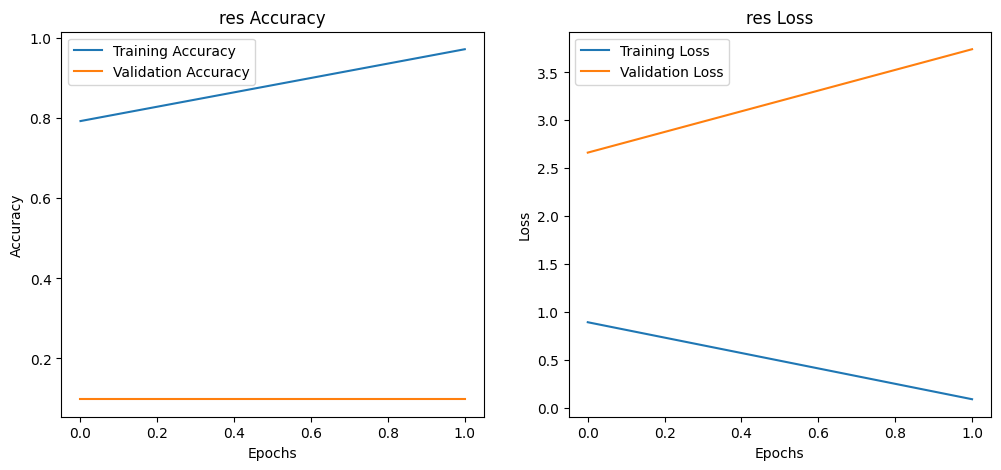


Training MobileNet...
Epoch 1/2
47/47 [==============================] - 132s 3s/step - loss: 1.2424 - accuracy: 0.5708 - val_loss: 2.3097 - val_accuracy: 0.0967
Epoch 2/2
47/47 [==============================] - 124s 3s/step - loss: 0.3382 - accuracy: 0.8878 - val_loss: 2.3263 - val_accuracy: 0.0967

Model Summary for MobileNet:
Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 16, 16, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32

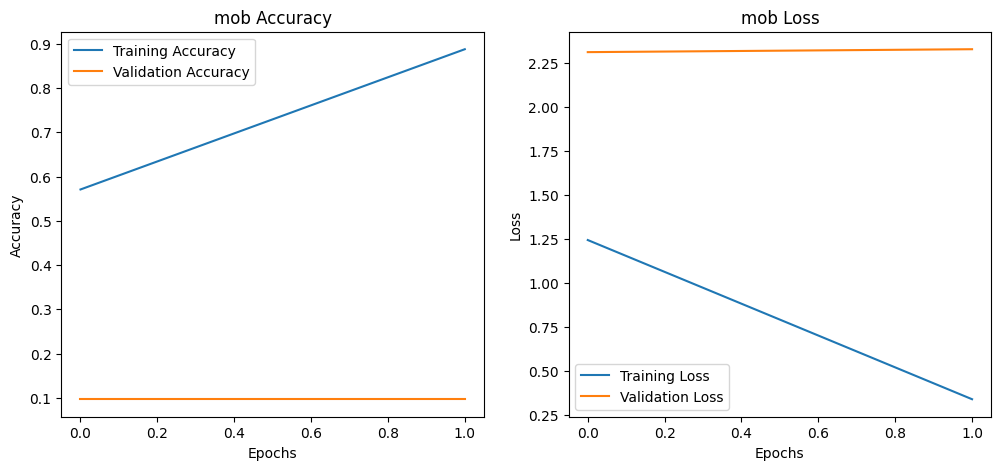


Training LeNet...
Epoch 1/2
38/38 [==============================] - 3s 48ms/step - loss: 1.1348 - accuracy: 0.7186 - val_loss: 0.4761 - val_accuracy: 0.8655
Epoch 2/2
38/38 [==============================] - 2s 43ms/step - loss: 0.4063 - accuracy: 0.8832 - val_loss: 0.3312 - val_accuracy: 0.9056

Model Summary for LeNet:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 12, 12, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 4, 4, 16)          0     

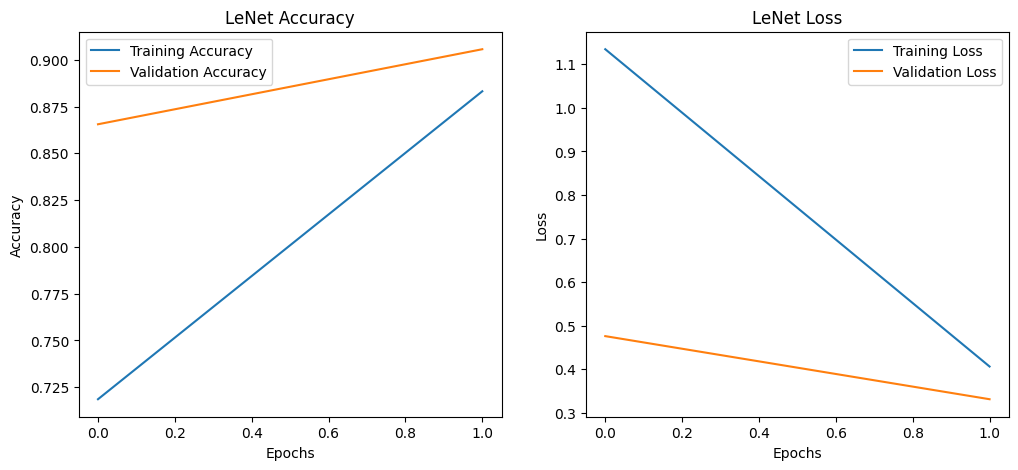


Training AlexNet...
Epoch 1/2
47/47 [==============================] - 294s 6s/step - loss: 0.8575 - accuracy: 0.7094 - val_loss: 0.0986 - val_accuracy: 0.9686
Epoch 2/2
47/47 [==============================] - 293s 6s/step - loss: 0.0697 - accuracy: 0.9788 - val_loss: 0.0489 - val_accuracy: 0.9859

Model Summary for AlexNet:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 192)         

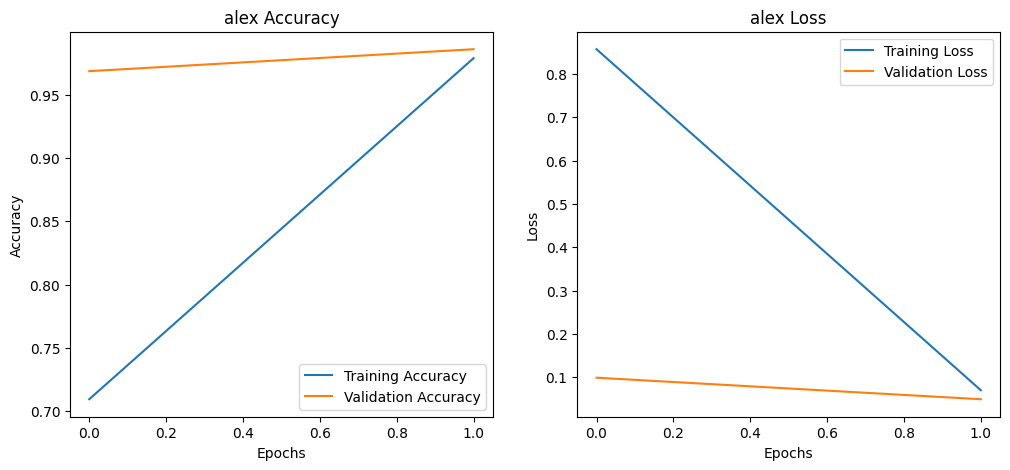


Training VGG16...
Epoch 1/2
47/47 [==============================] - 576s 12s/step - loss: 2.6663 - accuracy: 0.1194 - val_loss: 2.3028 - val_accuracy: 0.0980
Epoch 2/2
47/47 [==============================] - 565s 12s/step - loss: 2.3016 - accuracy: 0.1116 - val_loss: 2.3014 - val_accuracy: 0.1102

Model Summary for VGG16:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                

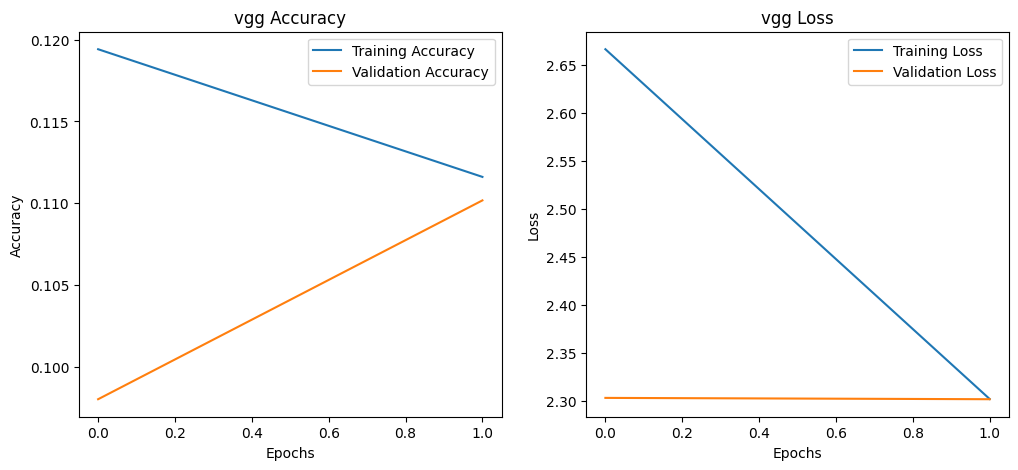

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess data
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension (28, 28) -> (28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Resize images for models that require 3 channels (like VGG16, ResNet50, MobileNet)
x_train_rgb = tf.image.grayscale_to_rgb(tf.constant(x_train))
x_test_rgb = tf.image.grayscale_to_rgb(tf.constant(x_test))
x_train_rgb = tf.image.resize(x_train_rgb, (32, 32))  # Resize to 32x32 for pre-trained models
x_test_rgb = tf.image.resize(x_test_rgb, (32, 32))

# Convert tensors to NumPy arrays
x_train_rgb = x_train_rgb.numpy()
x_test_rgb = x_test_rgb.numpy()

# Split the data into train and validation sets together
# Split data into train and validation sets (for both RGB and grayscale together)
x_train_rgb, x_val_rgb, x_train, x_val, y_train, y_val = train_test_split(
    x_train_rgb, x_train, y_train, test_size=0.2, random_state=42
)

x_train, x_val, y_train_gray, y_val_gray = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

def plot_metrics(history, model_name):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Compile and train function
def compile_and_train(model, model_name, train_data, val_data, input_shape):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"\nTraining {model_name}...")
    history = model.fit(train_data[0], train_data[1], epochs=2, batch_size=1024, validation_data=val_data)
    print(f"\nModel Summary for {model_name}:")
    model.summary()
    return history

# VGG16


# ResNet50
resnet50_model = ResNet50(weights=None, include_top=True, classes=10, input_shape=(32, 32, 3))
history_resnet50 = compile_and_train(resnet50_model, "ResNet50", (x_train_rgb, y_train), (x_val_rgb, y_val), (32, 32, 3))
plot_metrics(history_resnet50, "res")
# MobileNet
mobilenet_model = MobileNet(weights=None, include_top=True, classes=10, input_shape=(32, 32, 3))
history_mobilenet = compile_and_train(mobilenet_model, "MobileNet", (x_train_rgb, y_train), (x_val_rgb, y_val), (32, 32, 3))
plot_metrics(history_mobilenet, "mob")
# LeNet
def build_lenet():
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='tanh', input_shape=(28, 28, 1)),
        layers.AveragePooling2D((2, 2)),
        layers.Conv2D(16, (5, 5), activation='tanh'),
        layers.AveragePooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(10, activation='softmax')
    ])
    return model

lenet_model = build_lenet()
history_lenet = compile_and_train(lenet_model, "LeNet", (x_train, y_train_gray), (x_val, y_val_gray), (28, 28, 1))
plot_metrics(history_lenet, "LeNet")

# AlexNet
def build_alexnet():
    model = models.Sequential([
        # Adjusted first convolution to use smaller kernel and stride
        layers.Conv2D(64, (3, 3), strides=1, activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2), strides=2),

        # Adjusted kernel size for the second convolution
        layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Additional convolution layers
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

alexnet_model = build_alexnet()
history_alexnet = compile_and_train(alexnet_model, "AlexNet", (x_train_rgb, y_train), (x_val_rgb, y_val), (32, 32, 3))
plot_metrics(history_alexnet, "alex")

vgg16_model = VGG16(weights=None, include_top=True, classes=10, input_shape=(32, 32, 3))
history_vgg16 = compile_and_train(vgg16_model, "VGG16", (x_train_rgb, y_train), (x_val_rgb, y_val), (32, 32, 3))



plot_metrics(history_vgg16, "vgg")